# Sorting

In [2]:
import pandas as pd
df = pd.read_csv("YAG99.csv")

In [3]:
import os, json
import pandas as pd

def _clean(x):
    return str(x).replace("/", "-").replace("\\", "-").replace(" ", "_")

def split_cycles_sorted_by_patient_type(
    df: pd.DataFrame,
    metadata_json_path: str,
    patients_json_path: str,
    out_dir: str = "data",
    unknown_folder: str = "UNKNOWN",
    analyte_value: str = "analyte",
):
    os.makedirs(out_dir, exist_ok=True)

    # --- load metadata: run_id -> patient_id ---
    with open(metadata_json_path, "r") as f:
        meta_list = json.load(f)
    run_to_patient = {
        str(m["run_id"]): str(m["patient_id"])
        for m in meta_list
        if "run_id" in m and "patient_id" in m
    }

    # --- load patients: patient_id -> type ---
    with open(patients_json_path, "r") as f:
        patients_list = json.load(f)
    patient_to_type = {
        str(p["patient_id"]): str(p.get("type", unknown_folder)).strip()
        for p in patients_list
        if "patient_id" in p
    }

    df = df.copy()
    df["run_id"] = df["run_id"].astype(str)

    for (run_id, cycle), g in df.groupby(["run_id", "cycle"], sort=False):
        # keep only analyte rows
        if "section" in g.columns:
            g = g[g["section"] == analyte_value]
        else:
            # if there's no section column, skip (or you could just save as-is)
            continue

        # if the cycle has no analyte rows, skip writing
        if g.empty:
            continue

        pid = run_to_patient.get(run_id)

        # fallback: if metadata missing, try the df column if it exists
        if pid is None and "patient_id" in g.columns and not g["patient_id"].isna().all():
            pid = str(g["patient_id"].iloc[0])

        patient_type = patient_to_type.get(str(pid), unknown_folder)
        patient_type = _clean(patient_type) if patient_type else unknown_folder

        type_dir = os.path.join(out_dir, patient_type)
        os.makedirs(type_dir, exist_ok=True)

        fname = f"{_clean(run_id)}_{_clean(cycle)}.csv"
        g.to_csv(os.path.join(type_dir, fname), index=False)

# usage:
split_cycles_sorted_by_patient_type(
    df, "YAG99_metadata.json", "YAG99_patients.json", out_dir="data"
)



# Visualization

In [4]:
df.columns

Index(['run_id', 'cycle', 'relative_time_sec', 'section', 'humidity',
       'temperature', 'patient_id', '10_H0', '10_H1', '10_H2', '10_H3',
       '10_K2', '10_K3', '1_A0', '1_A1', '1_A2', '1_A3', '1_K0', '1_K1',
       '1_P0', '1_P1', '1_P2', '1_P3', '201_B0', '201_B1', '201_B2', '201_B3',
       '201_L0', '201_L1', '202_F0', '202_F1', '202_F2', '202_F3', '202_N0',
       '202_N1', '301_C0', '301_C1', '301_C2', '301_C3', '301_L2', '301_L3',
       '302_G0', '302_G1', '302_G2', '302_G3', '302_N2', '302_N3', '401_D0',
       '401_D1', '401_D2', '401_D3', '401_M0', '401_M1', '402_I0', '402_I1',
       '402_I2', '402_I3', '402_O0', '402_O1', '501_E0', '501_E1', '501_E2',
       '501_E3', '501_M2', '501_M3', '502_J0', '502_J1', '502_J2', '502_J3',
       '502_O2', '502_O3', 'avg_1', 'avg_10', 'avg_201', 'avg_202', 'avg_301',
       'avg_302', 'avg_401', 'avg_402', 'avg_501', 'avg_502'],
      dtype='object')

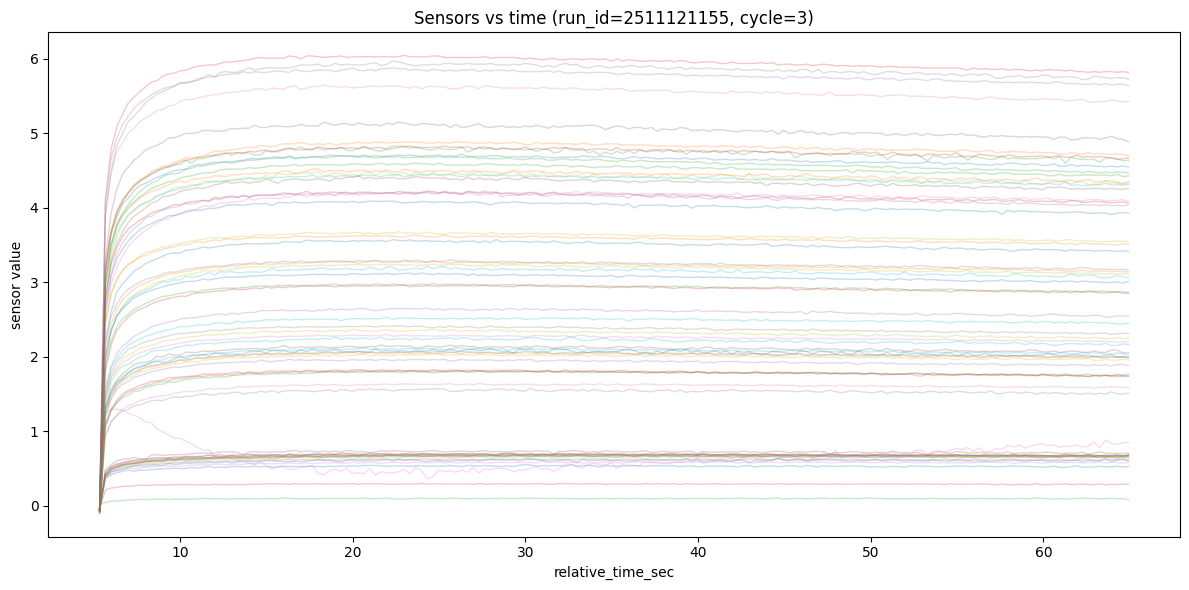

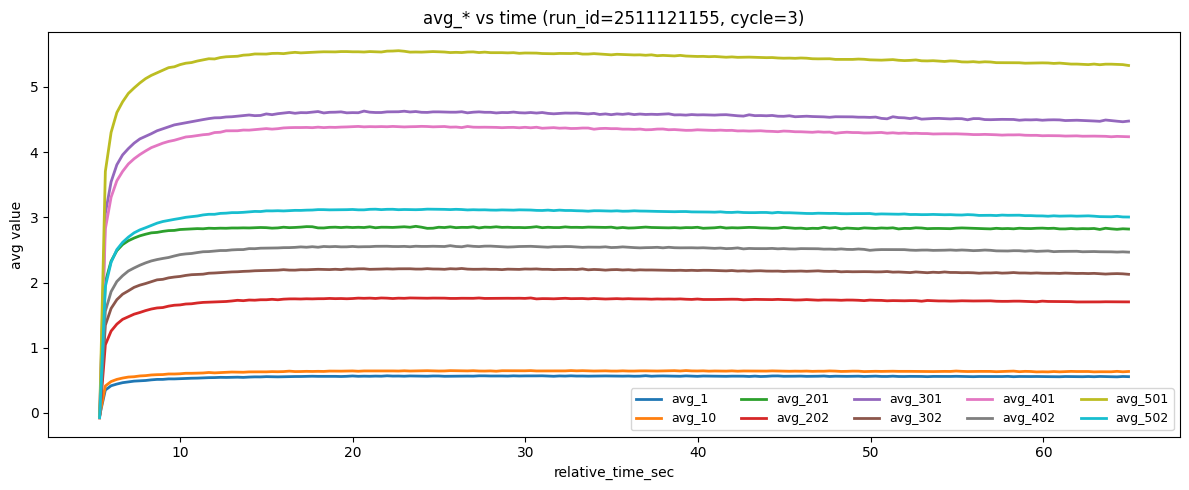

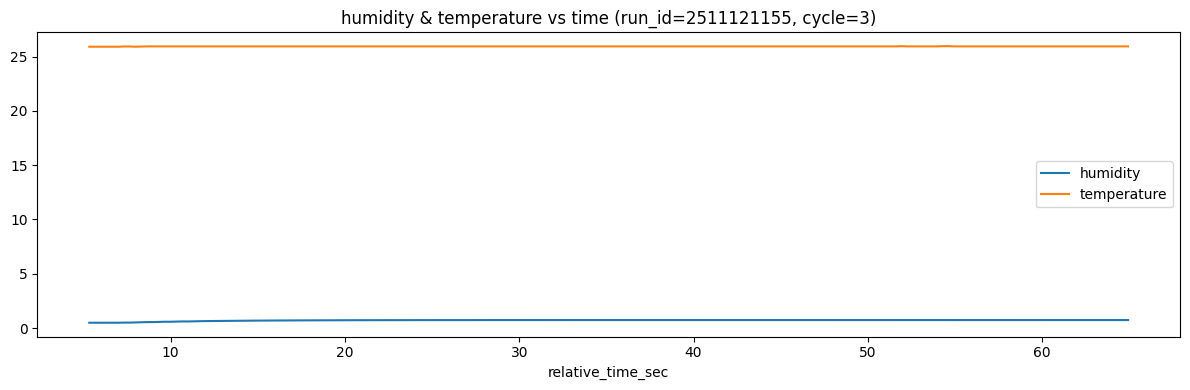

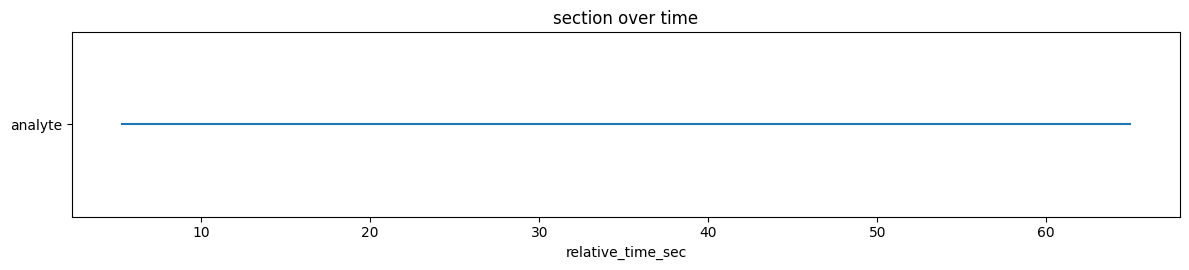

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_run_cycle_csv(csv_path: str):
    g = pd.read_csv(csv_path).sort_values("relative_time_sec")
    time = g["relative_time_sec"].to_numpy()

    id_cols = {"run_id","cycle","relative_time_sec","section","humidity","temperature","patient_id"}
    avg_cols = [c for c in g.columns if c.startswith("avg_")]
    sensor_cols = [c for c in g.columns if c not in id_cols and c not in avg_cols]

    # 1) All sensor channels
    plt.figure(figsize=(12, 6))
    for c in sensor_cols:
        plt.plot(time, g[c].to_numpy(), alpha=0.25, linewidth=1)
    title_run = g["run_id"].iloc[0] if "run_id" in g.columns else "?"
    title_cycle = g["cycle"].iloc[0] if "cycle" in g.columns else "?"
    plt.title(f"Sensors vs time (run_id={title_run}, cycle={title_cycle})")
    plt.xlabel("relative_time_sec")
    plt.ylabel("sensor value")
    plt.tight_layout()
    plt.show()

    # 2) avg_* columns
    if avg_cols:
        plt.figure(figsize=(12, 5))
        for c in avg_cols:
            plt.plot(time, g[c].to_numpy(), linewidth=2, label=c)
        plt.title(f"avg_* vs time (run_id={title_run}, cycle={title_cycle})")
        plt.xlabel("relative_time_sec")
        plt.ylabel("avg value")
        plt.legend(ncol=5, fontsize=9)
        plt.tight_layout()
        plt.show()

    # 3) humidity + temperature
    if {"humidity","temperature"}.issubset(g.columns):
        plt.figure(figsize=(12, 4))
        plt.plot(time, g["humidity"].to_numpy(), label="humidity")
        plt.plot(time, g["temperature"].to_numpy(), label="temperature")
        plt.title(f"humidity & temperature vs time (run_id={title_run}, cycle={title_cycle})")
        plt.xlabel("relative_time_sec")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 4) section (optional)
    if "section" in g.columns:
        codes, uniq = pd.factorize(g["section"])
        plt.figure(figsize=(12, 2.8))
        plt.step(time, codes, where="post")
        plt.yticks(range(len(uniq)), uniq)
        plt.title("section over time")
        plt.xlabel("relative_time_sec")
        plt.tight_layout()
        plt.show()

# usage:
visualize_run_cycle_csv("data/POSITIVE/2511121155_3.csv")


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ----------------
# Dataset
# ----------------
class CycleDataset(Dataset):
    def __init__(self, files, label_map, T=512, feature_cols=None):
        """
        Each file is a single (run_id, cycle) CSV (already analyte-only).
        Returns X: (C, T), y: int
        """
        self.files = files
        self.label_map = label_map
        self.T = T

        # Infer feature columns from the first file unless provided
        if feature_cols is None:
            df0 = pd.read_csv(files[0])
            id_cols = {"run_id","cycle","relative_time_sec","section","patient_id"}
            self.feature_cols = [c for c in df0.columns if c not in id_cols]
        else:
            self.feature_cols = list(feature_cols)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        df = pd.read_csv(path).sort_values("relative_time_sec")

        t = df["relative_time_sec"].to_numpy()
        X = df[self.feature_cols].to_numpy(dtype=np.float32)  # (N, C)

        # Resample to fixed length T
        t_grid = np.linspace(t.min(), t.max(), self.T)
        Xr = np.stack([np.interp(t_grid, t, X[:, c]) for c in range(X.shape[1])], axis=0)  # (C, T)

        # Label from parent folder name
        folder = os.path.basename(os.path.dirname(path))
        y = self.label_map[folder]

        return torch.from_numpy(Xr).float(), torch.tensor(y, dtype=torch.long)

# ----------------
# Model: Improved CNN1D with better regularization
# ----------------
class ImprovedCNN1D(nn.Module):
    def __init__(self, C, dropout=0.3):
        """
        Improved CNN1D with:
        - Deeper architecture (6 conv blocks)
        - Less aggressive pooling (keeps 64 timesteps before final pool)
        - Spatial dropout for regularization
        - More gradual channel expansion
        """
        super().__init__()
        
        # Block 1: 512 -> 512 (no pooling)
        self.conv1 = nn.Sequential(
            nn.Conv1d(C, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        # Block 2: 512 -> 256 (stride-2 conv for learned downsampling)
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 96, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(96),
            nn.ReLU(),
        )
        
        # Block 3: 256 -> 256 (no pooling, feature refinement)
        self.conv3 = nn.Sequential(
            nn.Conv1d(96, 96, kernel_size=5, padding=2),
            nn.BatchNorm1d(96),
            nn.ReLU(),
        )
        
        # Block 4: 256 -> 128 (stride-2 conv)
        self.conv4 = nn.Sequential(
            nn.Conv1d(96, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        # Block 5: 128 -> 128 (no pooling, feature refinement)
        self.conv5 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        # Block 6: 128 -> 64 (stride-2 conv)
        self.conv6 = nn.Sequential(
            nn.Conv1d(128, 192, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(192),
            nn.ReLU(),
        )
        
        # Global pooling: 64 timesteps -> 1
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head with additional regularization
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):  # (B, 80, 512)
        x = self.conv1(x)    # (B, 64, 512)
        x = self.conv2(x)    # (B, 96, 256)
        x = self.conv3(x)    # (B, 96, 256) - refinement
        x = self.conv4(x)    # (B, 128, 128)
        x = self.conv5(x)    # (B, 128, 128) - refinement
        x = self.conv6(x)    # (B, 192, 64)
        
        x = self.global_pool(x)  # (B, 192, 1)
        x = x.squeeze(-1)        # (B, 192)
        
        return self.head(x)      # (B, 2)

# ----------------
# Helpers
# ----------------
def list_csvs_by_class(root, class_names=("POSITIVE", "CONTROL")):
    files = []
    for cls in class_names:
        d = os.path.join(root, cls)
        if os.path.isdir(d):
            files += [os.path.join(d, f) for f in os.listdir(d) if f.endswith(".csv")]
    return files

@torch.no_grad()
def eval_epoch(model, dl, loss_fn, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss_sum / max(total, 1), correct / max(total, 1)

def train_epoch(model, dl, opt, loss_fn, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss_sum / max(total, 1), correct / max(total, 1)

# ----------------
# Main: 80/20 split + improved training with regularization
# ----------------
root = "data"  # expects data/POSITIVE/*.csv and data/CONTROL/*.csv
label_map = {"CONTROL": 0, "POSITIVE": 1}

all_files = list_csvs_by_class(root)
assert len(all_files) > 0, f"No CSVs found under {root}/POSITIVE or {root}/CONTROL"

# 80/20 split (file-level)
seed = 0
rng = random.Random(seed)
rng.shuffle(all_files)
split = int(0.8 * len(all_files))
train_files, test_files = all_files[:split], all_files[split:]

# Build train dataset first (to lock feature_cols), then reuse for test
train_ds = CycleDataset(train_files, label_map, T=512)
test_ds  = CycleDataset(test_files, label_map, T=512, feature_cols=train_ds.feature_cols)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN1D(C=len(train_ds.feature_cols), dropout=0.3).to(device)

# AdamW optimizer with weight decay for L2 regularization
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt, mode='max', factor=0.5, patience=3, verbose=True
# )

loss_fn = nn.CrossEntropyLoss()

# Training with early stopping
best_test_acc = 0
patience = 15
patience_counter = 0
epochs = 50

print("Starting training with ImprovedCNN1D...")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_epoch(model, train_dl, opt, loss_fn, device)
    te_loss, te_acc = eval_epoch(model, test_dl, loss_fn, device)
    
    # Update learning rate based on test accuracy
    # scheduler.step(te_acc)
    
    print(
        f"epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
        f"test  loss {te_loss:.4f} acc {te_acc:.3f}"
    )
    
    # Early stopping
    if te_acc > best_test_acc:
        best_test_acc = te_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  → New best test acc: {best_test_acc:.3f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

print(f"\nBest test accuracy: {best_test_acc:.3f}")

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pt'))
print("Loaded best model weights")


Starting training with ImprovedCNN1D...
Model parameters: 309,762
epoch 01 | train loss 0.4912 acc 0.802 | test  loss 0.6556 acc 0.563
  → New best test acc: 0.563
epoch 02 | train loss 0.3597 acc 0.856 | test  loss 0.8326 acc 0.586
  → New best test acc: 0.586
epoch 03 | train loss 0.3311 acc 0.876 | test  loss 0.6862 acc 0.701
  → New best test acc: 0.701
epoch 04 | train loss 0.3333 acc 0.871 | test  loss 0.9575 acc 0.713
  → New best test acc: 0.713
epoch 05 | train loss 0.3480 acc 0.874 | test  loss 2.7631 acc 0.460
epoch 06 | train loss 0.2924 acc 0.897 | test  loss 1.3928 acc 0.529
epoch 07 | train loss 0.3010 acc 0.891 | test  loss 0.6768 acc 0.782
  → New best test acc: 0.782


epoch 08 | train loss 0.2715 acc 0.899 | test  loss 0.4325 acc 0.839
  → New best test acc: 0.839
epoch 09 | train loss 0.2510 acc 0.899 | test  loss 1.8423 acc 0.586
epoch 10 | train loss 0.3099 acc 0.876 | test  loss 0.3654 acc 0.862
  → New best test acc: 0.862
epoch 11 | train loss 0.2456 acc 0.914 | test  loss 0.4380 acc 0.805
epoch 12 | train loss 0.2794 acc 0.888 | test  loss 0.3706 acc 0.793
epoch 13 | train loss 0.2887 acc 0.879 | test  loss 1.1820 acc 0.632
epoch 14 | train loss 0.2856 acc 0.876 | test  loss 0.8403 acc 0.667
epoch 15 | train loss 0.2597 acc 0.920 | test  loss 0.4554 acc 0.816
epoch 16 | train loss 0.2587 acc 0.911 | test  loss 0.3805 acc 0.851
epoch 17 | train loss 0.2450 acc 0.902 | test  loss 0.5124 acc 0.816
epoch 18 | train loss 0.2486 acc 0.897 | test  loss 0.9950 acc 0.759
epoch 19 | train loss 0.2370 acc 0.899 | test  loss 0.8224 acc 0.747
epoch 20 | train loss 0.2439 acc 0.914 | test  loss 0.7722 acc 0.770
epoch 21 | train loss 0.2657 acc 0.897 | test

In [ ]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def compute_test_auc(model, dl, device, positive_class=1):
    model.eval()
    y_true = []
    y_score = []

    for x, y in dl:
        x = x.to(device)
        logits = model(x)                       # (B, 2)
        probs = torch.softmax(logits, dim=1)    # (B, 2)

        y_true.append(y.cpu().numpy())
        y_score.append(probs[:, positive_class].cpu().numpy())

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)

    # NOTE: roc_auc_score requires both classes to be present in y_true
    return roc_auc_score(y_true, y_score)

auc = compute_test_auc(model, test_dl, device)
print(f"Test AUC: {auc:.4f}")


Test AUC: 0.9114


# Transformer

In [7]:
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score

# ----------------
# Dataset (same preprocessing: resample to fixed T)
# ----------------
class CycleDataset(Dataset):
    def __init__(self, files, label_map, T=512, feature_cols=None):
        self.files = files
        self.label_map = label_map
        self.T = T

        if feature_cols is None:
            df0 = pd.read_csv(files[0])
            id_cols = {"run_id","cycle","relative_time_sec","section","patient_id"}
            self.feature_cols = [c for c in df0.columns if c not in id_cols]
        else:
            self.feature_cols = list(feature_cols)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        df = pd.read_csv(path).sort_values("relative_time_sec")

        t = df["relative_time_sec"].to_numpy()
        X = df[self.feature_cols].to_numpy(dtype=np.float32)  # (N, C)

        t_grid = np.linspace(t.min(), t.max(), self.T)
        Xr = np.stack([np.interp(t_grid, t, X[:, c]) for c in range(X.shape[1])], axis=1)  # (T, C)

        folder = os.path.basename(os.path.dirname(path))
        y = self.label_map[folder]
        return torch.from_numpy(Xr).float(), torch.tensor(y, dtype=torch.long)  # X: (T, C)

def list_csvs_by_class(root, class_names=("POSITIVE", "CONTROL")):
    files = []
    for cls in class_names:
        d = os.path.join(root, cls)
        if os.path.isdir(d):
            files += [os.path.join(d, f) for f in os.listdir(d) if f.endswith(".csv")]
    return files

# ----------------
# Model: Transformer Encoder for time-series classification
# ----------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):  # x: (B, T, d_model)
        return x + self.pe[:, :x.size(1), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_ff=256, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = PositionalEncoding(d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 2),
        )

    def forward(self, x):           # x: (B, T, C)
        h = self.proj(x)            # (B, T, d_model)
        h = self.pos(h)
        h = self.encoder(h)         # (B, T, d_model)
        h = h.mean(dim=1)           # simple pooling over time (B, d_model)
        return self.cls_head(h)     # (B, 2)

# ----------------
# Train / Eval / AUC
# ----------------
def train_epoch(model, dl, opt, loss_fn, device, grad_clip=1.0):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        opt.zero_grad()
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()

        loss_sum += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return loss_sum / max(total, 1), correct / max(total, 1)

@torch.no_grad()
def eval_epoch(model, dl, loss_fn, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss_sum += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return loss_sum / max(total, 1), correct / max(total, 1)

@torch.no_grad()
def compute_auc(model, dl, device, positive_class=1):
    model.eval()
    ys, ps = [], []
    for x, y in dl:
        x = x.to(device)
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[:, positive_class]
        ys.append(y.numpy())
        ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys)
    y_score = np.concatenate(ps)
    return roc_auc_score(y_true, y_score)

# ----------------
# Main (80/20 split)
# ----------------
root = "data"  # expects data/POSITIVE/*.csv and data/CONTROL/*.csv
label_map = {"CONTROL": 0, "POSITIVE": 1}

files = list_csvs_by_class(root)
assert len(files) > 0, f"No CSVs found under {root}/POSITIVE or {root}/CONTROL"

seed = 0
rng = random.Random(seed)
rng.shuffle(files)
split = int(0.8 * len(files))
train_files, test_files = files[:split], files[split:]

train_ds = CycleDataset(train_files, label_map, T=512)
test_ds  = CycleDataset(test_files, label_map, T=512, feature_cols=train_ds.feature_cols)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(input_dim=len(train_ds.feature_cols), d_model=128, nhead=8, num_layers=4).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# epochs = 30
# for epoch in range(1, epochs + 1):
#     tr_loss, tr_acc = train_epoch(model, train_dl, opt, loss_fn, device)
#     te_loss, te_acc = eval_epoch(model, test_dl, loss_fn, device)
#     print(f"epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

# AUC (test)
# auc = compute_auc(model, test_dl, device)
# print(f"Test AUC: {auc:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
from dataclasses import dataclass

@dataclass
class TransformerConfig:
    # data
    root: str = "data"
    T: int = 512
    batch_size: int = 16
    seed: int = 0

    # model
    d_model: int = 128
    nhead: int = 8
    num_layers: int = 4
    dim_ff: int = 256
    dropout: float = 0.1

    # optimization
    lr: float = 2e-4
    weight_decay: float = 1e-2
    epochs: int = 30
    grad_clip: float = 1.0

    # misc
    device: str = "cpu"  # "cuda" or "cpu"


In [9]:
def train_transformer_with_config(cfg: TransformerConfig) -> float:
    import random
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader

    # ----------------
    # setup
    # ----------------
    label_map = {"CONTROL": 0, "POSITIVE": 1}

    files = list_csvs_by_class(cfg.root)
    assert len(files) > 0, f"No CSVs found under {cfg.root}/POSITIVE or {cfg.root}/CONTROL"

    rng = random.Random(cfg.seed)
    rng.shuffle(files)
    split = int(0.8 * len(files))
    train_files, test_files = files[:split], files[split:]

    train_ds = CycleDataset(train_files, label_map, T=cfg.T)
    test_ds  = CycleDataset(
        test_files,
        label_map,
        T=cfg.T,
        feature_cols=train_ds.feature_cols,
    )

    train_dl = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0,
    )
    test_dl = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0,
    )

    device = torch.device(
        cfg.device if (cfg.device == "cpu" or torch.cuda.is_available()) else "cpu"
    )

    model = TimeSeriesTransformer(
        input_dim=len(train_ds.feature_cols),
        d_model=cfg.d_model,
        nhead=cfg.nhead,
        num_layers=cfg.num_layers,
        dim_ff=cfg.dim_ff,
        dropout=cfg.dropout,
    ).to(device)

    opt = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.lr,
        weight_decay=cfg.weight_decay,
    )
    loss_fn = nn.CrossEntropyLoss()

    # ----------------
    # training loop
    # ----------------
    best_auc = -float("inf")

    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = train_epoch(
            model,
            train_dl,
            opt,
            loss_fn,
            device,
            grad_clip=cfg.grad_clip,
        )
        te_loss, te_acc = eval_epoch(
            model,
            test_dl,
            loss_fn,
            device,
        )

        auc = compute_auc(model, test_dl, device)
        best_auc = max(best_auc, auc)

        print(
            f"epoch {epoch:02d} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
            f"test loss {te_loss:.4f} acc {te_acc:.3f} | "
            f"auc {auc:.4f}"
        )

    return best_auc


In [12]:
import numpy as np
import torch

configs = []
for num_layers in range(1, 5):
    for num_heads in [1, 2, 4]:
        for lr in np.linspace(1e-4, 1e-3, 4):
            configs.append(
                TransformerConfig(
                    num_layers=num_layers,
                    nhead = num_heads,
                    lr = lr,
                    device = "cuda" if torch.cuda.is_available() else "cpu",
                    epochs = 10
                )
            )
            

In [13]:
best_auc, best_config = 0, None
for config in configs:
    auc = train_transformer_with_config(config)
    if auc > best_auc:
        best_auc = auc
        best_config = config
        
    if auc >= 0.93:
        print("found")
        break

    print("best_auc", best_auc)

print(best_auc, config)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6821 acc 0.578 | test loss 0.6566 acc 0.609 | auc 0.8040
epoch 02 | train loss 0.6401 acc 0.624 | test loss 0.6147 acc 0.621 | auc 0.8416
epoch 03 | train loss 0.5990 acc 0.644 | test loss 0.5722 acc 0.851 | auc 0.8792
epoch 04 | train loss 0.5642 acc 0.747 | test loss 0.5186 acc 0.851 | auc 0.8776
epoch 05 | train loss 0.5057 acc 0.830 | test loss 0.4657 acc 0.874 | auc 0.8668
epoch 06 | train loss 0.4268 acc 0.874 | test loss 0.4214 acc 0.862 | auc 0.8673
epoch 07 | train loss 0.4046 acc 0.876 | test loss 0.4190 acc 0.862 | auc 0.8598
epoch 08 | train loss 0.3961 acc 0.868 | test loss 0.4260 acc 0.862 | auc 0.8545
epoch 09 | train loss 0.3783 acc 0.879 | test loss 0.4346 acc 0.862 | auc 0.8561
epoch 10 | train loss 0.3791 acc 0.882 | test loss 0.4312 acc 0.862 | auc 0.8545
best_auc 0.8791621911922664


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6483 acc 0.601 | test loss 0.5670 acc 0.747 | auc 0.8695
epoch 02 | train loss 0.4931 acc 0.851 | test loss 0.4164 acc 0.862 | auc 0.8625
epoch 03 | train loss 0.4588 acc 0.810 | test loss 0.5447 acc 0.793 | auc 0.8604
epoch 04 | train loss 0.4008 acc 0.882 | test loss 0.4309 acc 0.862 | auc 0.8550
epoch 05 | train loss 0.3999 acc 0.856 | test loss 0.4852 acc 0.816 | auc 0.8507
epoch 06 | train loss 0.4238 acc 0.865 | test loss 0.4459 acc 0.816 | auc 0.8577
epoch 07 | train loss 0.3938 acc 0.868 | test loss 0.5046 acc 0.828 | auc 0.8695
epoch 08 | train loss 0.4030 acc 0.856 | test loss 0.4275 acc 0.862 | auc 0.8631
epoch 09 | train loss 0.3732 acc 0.885 | test loss 0.4293 acc 0.862 | auc 0.8620
epoch 10 | train loss 0.3979 acc 0.879 | test loss 0.4942 acc 0.862 | auc 0.8523
best_auc 0.8791621911922664


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6605 acc 0.647 | test loss 0.5109 acc 0.862 | auc 0.8700
epoch 02 | train loss 0.4666 acc 0.839 | test loss 0.5844 acc 0.828 | auc 0.8652
epoch 03 | train loss 0.4209 acc 0.845 | test loss 0.4530 acc 0.839 | auc 0.8695
epoch 04 | train loss 0.4185 acc 0.825 | test loss 0.4576 acc 0.816 | auc 0.8663
epoch 05 | train loss 0.3894 acc 0.856 | test loss 0.4478 acc 0.828 | auc 0.8652
epoch 06 | train loss 0.4387 acc 0.830 | test loss 0.4991 acc 0.793 | auc 0.8690
epoch 07 | train loss 0.4137 acc 0.848 | test loss 0.4684 acc 0.851 | auc 0.8754
epoch 08 | train loss 0.3989 acc 0.853 | test loss 0.4480 acc 0.862 | auc 0.8673
epoch 09 | train loss 0.3821 acc 0.859 | test loss 0.4088 acc 0.862 | auc 0.8700
epoch 10 | train loss 0.3785 acc 0.865 | test loss 0.5878 acc 0.782 | auc 0.8700
best_auc 0.8791621911922664


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6864 acc 0.569 | test loss 0.5615 acc 0.621 | auc 0.8824
epoch 02 | train loss 0.4863 acc 0.773 | test loss 0.4033 acc 0.862 | auc 0.8711
epoch 03 | train loss 0.4382 acc 0.836 | test loss 0.4877 acc 0.816 | auc 0.8765
epoch 04 | train loss 0.4281 acc 0.859 | test loss 0.5554 acc 0.805 | auc 0.8571
epoch 05 | train loss 0.4253 acc 0.842 | test loss 0.4136 acc 0.851 | auc 0.8829
epoch 06 | train loss 0.3965 acc 0.876 | test loss 0.4584 acc 0.862 | auc 0.8663
epoch 07 | train loss 0.4450 acc 0.871 | test loss 0.4494 acc 0.862 | auc 0.8716
epoch 08 | train loss 0.4224 acc 0.842 | test loss 0.4220 acc 0.851 | auc 0.8668
epoch 09 | train loss 0.3588 acc 0.897 | test loss 0.4457 acc 0.862 | auc 0.8593
epoch 10 | train loss 0.3834 acc 0.891 | test loss 0.4408 acc 0.862 | auc 0.8528
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7188 acc 0.606 | test loss 0.6498 acc 0.644 | auc 0.7374
epoch 02 | train loss 0.6328 acc 0.641 | test loss 0.6180 acc 0.621 | auc 0.8271
epoch 03 | train loss 0.6040 acc 0.693 | test loss 0.5849 acc 0.828 | auc 0.8561
epoch 04 | train loss 0.5622 acc 0.759 | test loss 0.5368 acc 0.862 | auc 0.8668
epoch 05 | train loss 0.5073 acc 0.853 | test loss 0.4768 acc 0.862 | auc 0.8743
epoch 06 | train loss 0.4535 acc 0.851 | test loss 0.4462 acc 0.862 | auc 0.8684
epoch 07 | train loss 0.4071 acc 0.865 | test loss 0.4370 acc 0.862 | auc 0.8566
epoch 08 | train loss 0.3859 acc 0.888 | test loss 0.4438 acc 0.862 | auc 0.8480
epoch 09 | train loss 0.3902 acc 0.882 | test loss 0.4337 acc 0.862 | auc 0.8485
epoch 10 | train loss 0.3899 acc 0.879 | test loss 0.4232 acc 0.862 | auc 0.8512
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6752 acc 0.621 | test loss 0.6152 acc 0.609 | auc 0.8695
epoch 02 | train loss 0.5151 acc 0.799 | test loss 0.4154 acc 0.862 | auc 0.8727
epoch 03 | train loss 0.4047 acc 0.856 | test loss 0.4515 acc 0.862 | auc 0.8561
epoch 04 | train loss 0.4013 acc 0.848 | test loss 0.5047 acc 0.816 | auc 0.8706
epoch 05 | train loss 0.3912 acc 0.859 | test loss 0.4404 acc 0.862 | auc 0.8604
epoch 06 | train loss 0.3959 acc 0.871 | test loss 0.4256 acc 0.862 | auc 0.8588
epoch 07 | train loss 0.4598 acc 0.822 | test loss 0.4226 acc 0.862 | auc 0.8620
epoch 08 | train loss 0.3830 acc 0.851 | test loss 0.4043 acc 0.862 | auc 0.8700
epoch 09 | train loss 0.4732 acc 0.842 | test loss 0.4800 acc 0.862 | auc 0.8566
epoch 10 | train loss 0.3703 acc 0.879 | test loss 0.4360 acc 0.862 | auc 0.8625
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6869 acc 0.615 | test loss 0.5619 acc 0.828 | auc 0.8727
epoch 02 | train loss 0.5055 acc 0.779 | test loss 0.4348 acc 0.851 | auc 0.8582
epoch 03 | train loss 0.4368 acc 0.830 | test loss 0.4141 acc 0.862 | auc 0.8598
epoch 04 | train loss 0.4081 acc 0.853 | test loss 0.5230 acc 0.770 | auc 0.8733
epoch 05 | train loss 0.4166 acc 0.830 | test loss 0.4982 acc 0.805 | auc 0.8631
epoch 06 | train loss 0.3927 acc 0.851 | test loss 0.4132 acc 0.862 | auc 0.8727
epoch 07 | train loss 0.4017 acc 0.865 | test loss 0.4291 acc 0.862 | auc 0.8593
epoch 08 | train loss 0.3617 acc 0.879 | test loss 0.4133 acc 0.862 | auc 0.8770
epoch 09 | train loss 0.3953 acc 0.874 | test loss 0.5144 acc 0.862 | auc 0.8652
epoch 10 | train loss 0.4168 acc 0.868 | test loss 0.4293 acc 0.862 | auc 0.8647
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6938 acc 0.603 | test loss 0.5829 acc 0.862 | auc 0.8818
epoch 02 | train loss 0.5734 acc 0.713 | test loss 0.6856 acc 0.621 | auc 0.8765
epoch 03 | train loss 0.5232 acc 0.750 | test loss 0.4194 acc 0.862 | auc 0.8657
epoch 04 | train loss 0.4227 acc 0.848 | test loss 0.4040 acc 0.862 | auc 0.8770
epoch 05 | train loss 0.4407 acc 0.848 | test loss 0.4057 acc 0.862 | auc 0.8808
epoch 06 | train loss 0.4046 acc 0.897 | test loss 0.4209 acc 0.862 | auc 0.8727
epoch 07 | train loss 0.4121 acc 0.845 | test loss 0.4637 acc 0.828 | auc 0.8743
epoch 08 | train loss 0.5292 acc 0.799 | test loss 0.4278 acc 0.862 | auc 0.8743
epoch 09 | train loss 0.3799 acc 0.865 | test loss 0.4313 acc 0.839 | auc 0.8786
epoch 10 | train loss 0.3789 acc 0.865 | test loss 0.4914 acc 0.839 | auc 0.8765
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6770 acc 0.609 | test loss 0.6661 acc 0.609 | auc 0.7621
epoch 02 | train loss 0.6426 acc 0.644 | test loss 0.6152 acc 0.690 | auc 0.8555
epoch 03 | train loss 0.6075 acc 0.624 | test loss 0.5869 acc 0.621 | auc 0.8652
epoch 04 | train loss 0.5689 acc 0.741 | test loss 0.5379 acc 0.828 | auc 0.8802
epoch 05 | train loss 0.5065 acc 0.859 | test loss 0.4704 acc 0.862 | auc 0.8759
epoch 06 | train loss 0.4463 acc 0.851 | test loss 0.4548 acc 0.816 | auc 0.8673
epoch 07 | train loss 0.4198 acc 0.853 | test loss 0.4077 acc 0.862 | auc 0.8663
epoch 08 | train loss 0.3911 acc 0.879 | test loss 0.4437 acc 0.862 | auc 0.8673
epoch 09 | train loss 0.4006 acc 0.865 | test loss 0.4205 acc 0.862 | auc 0.8636
epoch 10 | train loss 0.3818 acc 0.885 | test loss 0.4119 acc 0.862 | auc 0.8614
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7239 acc 0.555 | test loss 0.5849 acc 0.839 | auc 0.8743
epoch 02 | train loss 0.5571 acc 0.747 | test loss 0.4435 acc 0.862 | auc 0.8743
epoch 03 | train loss 0.4009 acc 0.862 | test loss 0.4980 acc 0.839 | auc 0.8716
epoch 04 | train loss 0.4326 acc 0.842 | test loss 0.4435 acc 0.816 | auc 0.8631
epoch 05 | train loss 0.3710 acc 0.865 | test loss 0.4165 acc 0.862 | auc 0.8776
epoch 06 | train loss 0.4054 acc 0.836 | test loss 0.4521 acc 0.828 | auc 0.8738
epoch 07 | train loss 0.3848 acc 0.859 | test loss 0.4023 acc 0.862 | auc 0.8733
epoch 08 | train loss 0.3636 acc 0.851 | test loss 0.4676 acc 0.828 | auc 0.8749
epoch 09 | train loss 0.4100 acc 0.874 | test loss 0.4742 acc 0.862 | auc 0.8695
epoch 10 | train loss 0.3650 acc 0.876 | test loss 0.4134 acc 0.862 | auc 0.8706
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6461 acc 0.626 | test loss 0.5559 acc 0.828 | auc 0.8749
epoch 02 | train loss 0.5192 acc 0.845 | test loss 0.6130 acc 0.828 | auc 0.8663
epoch 03 | train loss 0.5781 acc 0.741 | test loss 0.4165 acc 0.851 | auc 0.8716
epoch 04 | train loss 0.4293 acc 0.848 | test loss 0.4408 acc 0.862 | auc 0.8668
epoch 05 | train loss 0.3951 acc 0.876 | test loss 0.4155 acc 0.862 | auc 0.8727
epoch 06 | train loss 0.3864 acc 0.853 | test loss 0.4222 acc 0.862 | auc 0.8727
epoch 07 | train loss 0.4367 acc 0.842 | test loss 0.4543 acc 0.862 | auc 0.8673
epoch 08 | train loss 0.4319 acc 0.853 | test loss 0.4642 acc 0.862 | auc 0.8695
epoch 09 | train loss 0.3904 acc 0.862 | test loss 0.4333 acc 0.816 | auc 0.8695
epoch 10 | train loss 0.3623 acc 0.882 | test loss 0.4235 acc 0.862 | auc 0.8641
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6774 acc 0.598 | test loss 0.6701 acc 0.437 | auc 0.8459
epoch 02 | train loss 0.5554 acc 0.724 | test loss 0.5160 acc 0.736 | auc 0.8733
epoch 03 | train loss 0.4292 acc 0.842 | test loss 0.4379 acc 0.793 | auc 0.8700
epoch 04 | train loss 0.4134 acc 0.848 | test loss 0.4620 acc 0.839 | auc 0.8711
epoch 05 | train loss 0.4093 acc 0.856 | test loss 0.4234 acc 0.862 | auc 0.8818
epoch 06 | train loss 0.4077 acc 0.859 | test loss 0.4507 acc 0.828 | auc 0.8759
epoch 07 | train loss 0.3808 acc 0.856 | test loss 0.5526 acc 0.793 | auc 0.8765
epoch 08 | train loss 0.4583 acc 0.836 | test loss 0.4063 acc 0.862 | auc 0.8738
epoch 09 | train loss 0.3635 acc 0.879 | test loss 0.4651 acc 0.851 | auc 0.8770
epoch 10 | train loss 0.4212 acc 0.833 | test loss 0.4196 acc 0.862 | auc 0.8770
best_auc 0.882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6664 acc 0.609 | test loss 0.6286 acc 0.690 | auc 0.7197
epoch 02 | train loss 0.6245 acc 0.635 | test loss 0.5852 acc 0.621 | auc 0.8711
epoch 03 | train loss 0.5691 acc 0.744 | test loss 0.5552 acc 0.621 | auc 0.8845
epoch 04 | train loss 0.5105 acc 0.790 | test loss 0.4551 acc 0.816 | auc 0.8759
epoch 05 | train loss 0.4148 acc 0.882 | test loss 0.4090 acc 0.862 | auc 0.8711
epoch 06 | train loss 0.4049 acc 0.865 | test loss 0.4720 acc 0.839 | auc 0.8781
epoch 07 | train loss 0.3962 acc 0.876 | test loss 0.4100 acc 0.862 | auc 0.8716
epoch 08 | train loss 0.3785 acc 0.874 | test loss 0.4092 acc 0.862 | auc 0.8700
epoch 09 | train loss 0.3870 acc 0.879 | test loss 0.4352 acc 0.862 | auc 0.8695
epoch 10 | train loss 0.3786 acc 0.874 | test loss 0.4034 acc 0.862 | auc 0.8722
best_auc 0.8845327604726101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6446 acc 0.609 | test loss 0.5407 acc 0.759 | auc 0.8367
epoch 02 | train loss 0.5007 acc 0.770 | test loss 0.5064 acc 0.828 | auc 0.8647
epoch 03 | train loss 0.4209 acc 0.848 | test loss 0.5433 acc 0.759 | auc 0.8512
epoch 04 | train loss 0.4764 acc 0.822 | test loss 0.4185 acc 0.862 | auc 0.8582
epoch 05 | train loss 0.3991 acc 0.833 | test loss 0.4094 acc 0.862 | auc 0.8722
epoch 06 | train loss 0.4054 acc 0.856 | test loss 0.4075 acc 0.805 | auc 0.8716
epoch 07 | train loss 0.3726 acc 0.865 | test loss 0.4689 acc 0.828 | auc 0.8733
epoch 08 | train loss 0.3945 acc 0.879 | test loss 0.4144 acc 0.862 | auc 0.8700
epoch 09 | train loss 0.4143 acc 0.871 | test loss 0.4540 acc 0.839 | auc 0.8690
epoch 10 | train loss 0.3725 acc 0.876 | test loss 0.4378 acc 0.862 | auc 0.8684
best_auc 0.8845327604726101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6493 acc 0.629 | test loss 0.4865 acc 0.839 | auc 0.8786
epoch 02 | train loss 0.4861 acc 0.802 | test loss 0.4064 acc 0.862 | auc 0.8706
epoch 03 | train loss 0.4427 acc 0.836 | test loss 0.4260 acc 0.862 | auc 0.8743
epoch 04 | train loss 0.4326 acc 0.839 | test loss 0.4480 acc 0.839 | auc 0.8711
epoch 05 | train loss 0.4276 acc 0.822 | test loss 0.4597 acc 0.839 | auc 0.8727
epoch 06 | train loss 0.4166 acc 0.868 | test loss 0.4094 acc 0.862 | auc 0.8765
epoch 07 | train loss 0.4055 acc 0.874 | test loss 0.5370 acc 0.759 | auc 0.8716
epoch 08 | train loss 0.3944 acc 0.865 | test loss 0.5063 acc 0.839 | auc 0.8700
epoch 09 | train loss 0.3998 acc 0.851 | test loss 0.4139 acc 0.862 | auc 0.8733
epoch 10 | train loss 0.3577 acc 0.882 | test loss 0.4042 acc 0.862 | auc 0.8749
best_auc 0.8845327604726101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.5735 acc 0.716 | test loss 0.4515 acc 0.839 | auc 0.8722
epoch 02 | train loss 0.4935 acc 0.833 | test loss 0.4439 acc 0.839 | auc 0.8695
epoch 03 | train loss 0.3948 acc 0.853 | test loss 0.4786 acc 0.793 | auc 0.8647
epoch 04 | train loss 0.4975 acc 0.816 | test loss 0.4028 acc 0.862 | auc 0.8776
epoch 05 | train loss 0.4051 acc 0.853 | test loss 0.4485 acc 0.862 | auc 0.8593
epoch 06 | train loss 0.3809 acc 0.885 | test loss 0.4286 acc 0.816 | auc 0.8824
epoch 07 | train loss 0.3835 acc 0.856 | test loss 0.4308 acc 0.862 | auc 0.8722
epoch 08 | train loss 0.3834 acc 0.885 | test loss 0.4430 acc 0.862 | auc 0.8759
epoch 09 | train loss 0.3920 acc 0.865 | test loss 0.4715 acc 0.862 | auc 0.8652
epoch 10 | train loss 0.4006 acc 0.862 | test loss 0.4377 acc 0.862 | auc 0.8759
best_auc 0.8845327604726101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6589 acc 0.566 | test loss 0.6312 acc 0.575 | auc 0.8786
epoch 02 | train loss 0.5868 acc 0.727 | test loss 0.5555 acc 0.632 | auc 0.8716
epoch 03 | train loss 0.5183 acc 0.825 | test loss 0.4849 acc 0.839 | auc 0.8738
epoch 04 | train loss 0.4549 acc 0.859 | test loss 0.4182 acc 0.862 | auc 0.8684
epoch 05 | train loss 0.4042 acc 0.868 | test loss 0.4362 acc 0.862 | auc 0.8598
epoch 06 | train loss 0.4082 acc 0.853 | test loss 0.4112 acc 0.862 | auc 0.8598
epoch 07 | train loss 0.3944 acc 0.868 | test loss 0.4348 acc 0.828 | auc 0.8641
epoch 08 | train loss 0.3827 acc 0.871 | test loss 0.4219 acc 0.828 | auc 0.8636
epoch 09 | train loss 0.3746 acc 0.882 | test loss 0.4309 acc 0.839 | auc 0.8641
epoch 10 | train loss 0.3710 acc 0.856 | test loss 0.4369 acc 0.862 | auc 0.8598
best_auc 0.8845327604726101


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6298 acc 0.647 | test loss 0.5581 acc 0.621 | auc 0.8695
epoch 02 | train loss 0.4609 acc 0.830 | test loss 0.5013 acc 0.782 | auc 0.8614
epoch 03 | train loss 0.4426 acc 0.845 | test loss 0.4536 acc 0.839 | auc 0.8802
epoch 04 | train loss 0.3993 acc 0.836 | test loss 0.4187 acc 0.862 | auc 0.8663
epoch 05 | train loss 0.4140 acc 0.842 | test loss 0.4765 acc 0.828 | auc 0.8738
epoch 06 | train loss 0.3863 acc 0.874 | test loss 0.4306 acc 0.862 | auc 0.8722
epoch 07 | train loss 0.4218 acc 0.845 | test loss 0.3989 acc 0.862 | auc 0.8722
epoch 08 | train loss 0.4210 acc 0.851 | test loss 0.4758 acc 0.839 | auc 0.8878
epoch 09 | train loss 0.3841 acc 0.871 | test loss 0.4151 acc 0.862 | auc 0.8738
epoch 10 | train loss 0.3719 acc 0.868 | test loss 0.4111 acc 0.839 | auc 0.8883
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6673 acc 0.638 | test loss 0.6380 acc 0.621 | auc 0.8647
epoch 02 | train loss 0.6378 acc 0.707 | test loss 0.7440 acc 0.598 | auc 0.8716
epoch 03 | train loss 0.4622 acc 0.825 | test loss 0.4276 acc 0.816 | auc 0.8690
epoch 04 | train loss 0.3964 acc 0.845 | test loss 0.4446 acc 0.862 | auc 0.8598
epoch 05 | train loss 0.3737 acc 0.876 | test loss 0.4941 acc 0.816 | auc 0.8749
epoch 06 | train loss 0.5180 acc 0.790 | test loss 0.5588 acc 0.782 | auc 0.8663
epoch 07 | train loss 0.4482 acc 0.851 | test loss 0.5331 acc 0.805 | auc 0.8663
epoch 08 | train loss 0.4016 acc 0.871 | test loss 0.4538 acc 0.862 | auc 0.8631
epoch 09 | train loss 0.3745 acc 0.885 | test loss 0.4779 acc 0.862 | auc 0.8647
epoch 10 | train loss 0.4003 acc 0.882 | test loss 0.4706 acc 0.839 | auc 0.8765
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6682 acc 0.615 | test loss 0.5156 acc 0.839 | auc 0.8835
epoch 02 | train loss 0.5248 acc 0.764 | test loss 0.4624 acc 0.851 | auc 0.8695
epoch 03 | train loss 0.4015 acc 0.833 | test loss 0.4114 acc 0.862 | auc 0.8856
epoch 04 | train loss 0.4795 acc 0.848 | test loss 0.7049 acc 0.736 | auc 0.8577
epoch 05 | train loss 0.4232 acc 0.851 | test loss 0.3946 acc 0.862 | auc 0.8872
epoch 06 | train loss 0.3857 acc 0.868 | test loss 0.4767 acc 0.828 | auc 0.8878
epoch 07 | train loss 0.3890 acc 0.862 | test loss 0.4121 acc 0.862 | auc 0.8770
epoch 08 | train loss 0.4371 acc 0.859 | test loss 0.4007 acc 0.862 | auc 0.8872
epoch 09 | train loss 0.3584 acc 0.879 | test loss 0.4420 acc 0.862 | auc 0.8765
epoch 10 | train loss 0.3575 acc 0.885 | test loss 0.4435 acc 0.862 | auc 0.8706
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6705 acc 0.575 | test loss 0.6304 acc 0.609 | auc 0.8668
epoch 02 | train loss 0.6019 acc 0.698 | test loss 0.5569 acc 0.770 | auc 0.8582
epoch 03 | train loss 0.5302 acc 0.842 | test loss 0.4798 acc 0.862 | auc 0.8700
epoch 04 | train loss 0.4399 acc 0.862 | test loss 0.4360 acc 0.862 | auc 0.8700
epoch 05 | train loss 0.4093 acc 0.851 | test loss 0.4957 acc 0.839 | auc 0.8641
epoch 06 | train loss 0.4233 acc 0.839 | test loss 0.4599 acc 0.839 | auc 0.8641
epoch 07 | train loss 0.4035 acc 0.856 | test loss 0.4161 acc 0.862 | auc 0.8539
epoch 08 | train loss 0.3767 acc 0.876 | test loss 0.4262 acc 0.862 | auc 0.8507
epoch 09 | train loss 0.3870 acc 0.865 | test loss 0.4355 acc 0.839 | auc 0.8593
epoch 10 | train loss 0.3737 acc 0.894 | test loss 0.4334 acc 0.862 | auc 0.8577
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6075 acc 0.693 | test loss 0.4754 acc 0.874 | auc 0.8722
epoch 02 | train loss 0.4381 acc 0.856 | test loss 0.5701 acc 0.736 | auc 0.8523
epoch 03 | train loss 0.4266 acc 0.830 | test loss 0.4282 acc 0.839 | auc 0.8711
epoch 04 | train loss 0.4295 acc 0.859 | test loss 0.5958 acc 0.770 | auc 0.8776
epoch 05 | train loss 0.4231 acc 0.859 | test loss 0.4199 acc 0.828 | auc 0.8835
epoch 06 | train loss 0.3874 acc 0.865 | test loss 0.4057 acc 0.862 | auc 0.8824
epoch 07 | train loss 0.4080 acc 0.862 | test loss 0.5258 acc 0.862 | auc 0.8722
epoch 08 | train loss 0.4505 acc 0.842 | test loss 0.4128 acc 0.862 | auc 0.8840
epoch 09 | train loss 0.3752 acc 0.865 | test loss 0.4121 acc 0.862 | auc 0.8845
epoch 10 | train loss 0.3809 acc 0.871 | test loss 0.4757 acc 0.862 | auc 0.8786
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6384 acc 0.664 | test loss 0.4842 acc 0.828 | auc 0.8749
epoch 02 | train loss 0.5195 acc 0.787 | test loss 0.4441 acc 0.839 | auc 0.8657
epoch 03 | train loss 0.4138 acc 0.839 | test loss 0.5947 acc 0.701 | auc 0.8604
epoch 04 | train loss 0.4288 acc 0.810 | test loss 0.5297 acc 0.816 | auc 0.8577
epoch 05 | train loss 0.4196 acc 0.851 | test loss 0.4166 acc 0.862 | auc 0.8754
epoch 06 | train loss 0.4088 acc 0.853 | test loss 0.5254 acc 0.759 | auc 0.8690
epoch 07 | train loss 0.3779 acc 0.853 | test loss 0.4248 acc 0.862 | auc 0.8690
epoch 08 | train loss 0.3652 acc 0.868 | test loss 0.4745 acc 0.862 | auc 0.8604
epoch 09 | train loss 0.3875 acc 0.862 | test loss 0.4588 acc 0.862 | auc 0.8523
epoch 10 | train loss 0.3768 acc 0.876 | test loss 0.5369 acc 0.747 | auc 0.8593
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.5728 acc 0.704 | test loss 0.4081 acc 0.862 | auc 0.8749
epoch 02 | train loss 0.4463 acc 0.839 | test loss 0.4013 acc 0.862 | auc 0.8856
epoch 03 | train loss 0.4407 acc 0.853 | test loss 0.6384 acc 0.724 | auc 0.8765
epoch 04 | train loss 0.4311 acc 0.836 | test loss 0.4601 acc 0.839 | auc 0.8829
epoch 05 | train loss 0.4011 acc 0.859 | test loss 0.4202 acc 0.862 | auc 0.8829
epoch 06 | train loss 0.4118 acc 0.874 | test loss 0.4200 acc 0.862 | auc 0.8749
epoch 07 | train loss 0.3807 acc 0.888 | test loss 0.4384 acc 0.862 | auc 0.8754
epoch 08 | train loss 0.3932 acc 0.862 | test loss 0.4252 acc 0.828 | auc 0.8759
epoch 09 | train loss 0.3797 acc 0.859 | test loss 0.4246 acc 0.839 | auc 0.8743
epoch 10 | train loss 0.3571 acc 0.885 | test loss 0.4296 acc 0.862 | auc 0.8733
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6620 acc 0.638 | test loss 0.6278 acc 0.609 | auc 0.8539
epoch 02 | train loss 0.6241 acc 0.701 | test loss 0.5889 acc 0.862 | auc 0.8711
epoch 03 | train loss 0.5714 acc 0.784 | test loss 0.5063 acc 0.747 | auc 0.8663
epoch 04 | train loss 0.4763 acc 0.787 | test loss 0.4323 acc 0.862 | auc 0.8733
epoch 05 | train loss 0.4135 acc 0.856 | test loss 0.6298 acc 0.736 | auc 0.8582
epoch 06 | train loss 0.4229 acc 0.836 | test loss 0.4169 acc 0.862 | auc 0.8647
epoch 07 | train loss 0.3811 acc 0.865 | test loss 0.4488 acc 0.839 | auc 0.8695
epoch 08 | train loss 0.3825 acc 0.871 | test loss 0.4289 acc 0.862 | auc 0.8770
epoch 09 | train loss 0.3851 acc 0.876 | test loss 0.4415 acc 0.862 | auc 0.8743
epoch 10 | train loss 0.3907 acc 0.853 | test loss 0.4777 acc 0.839 | auc 0.8781
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6714 acc 0.603 | test loss 0.5594 acc 0.747 | auc 0.8840
epoch 02 | train loss 0.4737 acc 0.819 | test loss 0.4325 acc 0.862 | auc 0.8695
epoch 03 | train loss 0.3958 acc 0.876 | test loss 0.4075 acc 0.874 | auc 0.8786
epoch 04 | train loss 0.3944 acc 0.853 | test loss 0.4481 acc 0.839 | auc 0.8663
epoch 05 | train loss 0.3892 acc 0.865 | test loss 0.4266 acc 0.862 | auc 0.8711
epoch 06 | train loss 0.3775 acc 0.865 | test loss 0.3949 acc 0.862 | auc 0.8818
epoch 07 | train loss 0.3654 acc 0.894 | test loss 0.5195 acc 0.839 | auc 0.8749
epoch 08 | train loss 0.3719 acc 0.882 | test loss 0.4134 acc 0.862 | auc 0.8765
epoch 09 | train loss 0.3724 acc 0.876 | test loss 0.4256 acc 0.862 | auc 0.8797
epoch 10 | train loss 0.3484 acc 0.891 | test loss 0.4094 acc 0.862 | auc 0.8706
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6404 acc 0.652 | test loss 0.5221 acc 0.793 | auc 0.8652
epoch 02 | train loss 0.4927 acc 0.833 | test loss 0.4356 acc 0.862 | auc 0.8695
epoch 03 | train loss 0.4368 acc 0.859 | test loss 0.4031 acc 0.862 | auc 0.8754
epoch 04 | train loss 0.4122 acc 0.856 | test loss 0.5897 acc 0.736 | auc 0.8679
epoch 05 | train loss 0.4126 acc 0.859 | test loss 0.4406 acc 0.851 | auc 0.8851
epoch 06 | train loss 0.3914 acc 0.871 | test loss 0.4009 acc 0.862 | auc 0.8792
epoch 07 | train loss 0.3872 acc 0.853 | test loss 0.5609 acc 0.747 | auc 0.8706
epoch 08 | train loss 0.4396 acc 0.822 | test loss 0.4562 acc 0.862 | auc 0.8711
epoch 09 | train loss 0.3893 acc 0.871 | test loss 0.4015 acc 0.851 | auc 0.8835
epoch 10 | train loss 0.4133 acc 0.853 | test loss 0.4680 acc 0.805 | auc 0.8765
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6637 acc 0.606 | test loss 0.5522 acc 0.805 | auc 0.8792
epoch 02 | train loss 0.5676 acc 0.779 | test loss 0.5292 acc 0.782 | auc 0.8802
epoch 03 | train loss 0.4184 acc 0.868 | test loss 0.4046 acc 0.862 | auc 0.8700
epoch 04 | train loss 0.5394 acc 0.776 | test loss 0.4263 acc 0.828 | auc 0.8727
epoch 05 | train loss 0.4797 acc 0.802 | test loss 0.4225 acc 0.862 | auc 0.8824
epoch 06 | train loss 0.3986 acc 0.871 | test loss 0.4931 acc 0.862 | auc 0.8679
epoch 07 | train loss 0.3645 acc 0.871 | test loss 0.4207 acc 0.862 | auc 0.8776
epoch 08 | train loss 0.4041 acc 0.865 | test loss 0.4742 acc 0.782 | auc 0.8851
epoch 09 | train loss 0.3730 acc 0.871 | test loss 0.4308 acc 0.862 | auc 0.8706
epoch 10 | train loss 0.3456 acc 0.894 | test loss 0.4343 acc 0.828 | auc 0.8818
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7275 acc 0.557 | test loss 0.6223 acc 0.621 | auc 0.8083
epoch 02 | train loss 0.6097 acc 0.701 | test loss 0.5905 acc 0.621 | auc 0.8759
epoch 03 | train loss 0.5574 acc 0.776 | test loss 0.5572 acc 0.621 | auc 0.8829
epoch 04 | train loss 0.4942 acc 0.805 | test loss 0.4255 acc 0.862 | auc 0.8749
epoch 05 | train loss 0.4074 acc 0.882 | test loss 0.4136 acc 0.839 | auc 0.8727
epoch 06 | train loss 0.3926 acc 0.894 | test loss 0.4206 acc 0.862 | auc 0.8673
epoch 07 | train loss 0.3996 acc 0.879 | test loss 0.4036 acc 0.862 | auc 0.8641
epoch 08 | train loss 0.3853 acc 0.879 | test loss 0.4124 acc 0.862 | auc 0.8695
epoch 09 | train loss 0.3837 acc 0.871 | test loss 0.4221 acc 0.862 | auc 0.8641
epoch 10 | train loss 0.3734 acc 0.868 | test loss 0.4111 acc 0.862 | auc 0.8706
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6086 acc 0.670 | test loss 0.4888 acc 0.805 | auc 0.8722
epoch 02 | train loss 0.5141 acc 0.828 | test loss 0.5568 acc 0.816 | auc 0.8663
epoch 03 | train loss 0.4384 acc 0.822 | test loss 0.4932 acc 0.782 | auc 0.8727
epoch 04 | train loss 0.3802 acc 0.876 | test loss 0.4240 acc 0.862 | auc 0.8604
epoch 05 | train loss 0.3862 acc 0.848 | test loss 0.4666 acc 0.862 | auc 0.8647
epoch 06 | train loss 0.3691 acc 0.868 | test loss 0.4224 acc 0.862 | auc 0.8716
epoch 07 | train loss 0.3851 acc 0.868 | test loss 0.4669 acc 0.862 | auc 0.8636
epoch 08 | train loss 0.3667 acc 0.856 | test loss 0.5454 acc 0.862 | auc 0.8534
epoch 09 | train loss 0.4096 acc 0.871 | test loss 0.4196 acc 0.862 | auc 0.8641
epoch 10 | train loss 0.3839 acc 0.851 | test loss 0.4144 acc 0.862 | auc 0.8631
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.5620 acc 0.690 | test loss 0.7341 acc 0.736 | auc 0.8754
epoch 02 | train loss 0.4694 acc 0.848 | test loss 0.5071 acc 0.839 | auc 0.8684
epoch 03 | train loss 0.4020 acc 0.836 | test loss 0.5893 acc 0.713 | auc 0.8716
epoch 04 | train loss 0.4828 acc 0.793 | test loss 0.5455 acc 0.770 | auc 0.8733
epoch 05 | train loss 0.4690 acc 0.830 | test loss 0.5299 acc 0.862 | auc 0.8690
epoch 06 | train loss 0.4158 acc 0.871 | test loss 0.4506 acc 0.862 | auc 0.8679
epoch 07 | train loss 0.3711 acc 0.876 | test loss 0.4244 acc 0.839 | auc 0.8684
epoch 08 | train loss 0.4016 acc 0.839 | test loss 0.4603 acc 0.862 | auc 0.8663
epoch 09 | train loss 0.3694 acc 0.865 | test loss 0.4757 acc 0.862 | auc 0.8641
epoch 10 | train loss 0.3899 acc 0.853 | test loss 0.4272 acc 0.839 | auc 0.8571
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.8398 acc 0.526 | test loss 0.6842 acc 0.586 | auc 0.8722
epoch 02 | train loss 0.5995 acc 0.687 | test loss 0.4295 acc 0.839 | auc 0.8792
epoch 03 | train loss 0.5779 acc 0.799 | test loss 0.4789 acc 0.805 | auc 0.8808
epoch 04 | train loss 0.4484 acc 0.839 | test loss 0.6416 acc 0.759 | auc 0.8797
epoch 05 | train loss 0.4206 acc 0.839 | test loss 0.3938 acc 0.862 | auc 0.8808
epoch 06 | train loss 0.3574 acc 0.874 | test loss 0.4474 acc 0.862 | auc 0.8749
epoch 07 | train loss 0.3742 acc 0.882 | test loss 0.4085 acc 0.862 | auc 0.8706
epoch 08 | train loss 0.3891 acc 0.862 | test loss 0.4493 acc 0.862 | auc 0.8716
epoch 09 | train loss 0.4497 acc 0.816 | test loss 0.4348 acc 0.851 | auc 0.8792
epoch 10 | train loss 0.3511 acc 0.894 | test loss 0.4425 acc 0.862 | auc 0.8684
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7098 acc 0.595 | test loss 0.6399 acc 0.632 | auc 0.7841
epoch 02 | train loss 0.6158 acc 0.635 | test loss 0.5686 acc 0.747 | auc 0.8647
epoch 03 | train loss 0.5438 acc 0.799 | test loss 0.4981 acc 0.805 | auc 0.8754
epoch 04 | train loss 0.5041 acc 0.805 | test loss 0.4735 acc 0.851 | auc 0.8759
epoch 05 | train loss 0.4332 acc 0.833 | test loss 0.4303 acc 0.839 | auc 0.8690
epoch 06 | train loss 0.4315 acc 0.830 | test loss 0.4124 acc 0.862 | auc 0.8598
epoch 07 | train loss 0.3912 acc 0.874 | test loss 0.4247 acc 0.862 | auc 0.8582
epoch 08 | train loss 0.3996 acc 0.859 | test loss 0.4703 acc 0.839 | auc 0.8528
epoch 09 | train loss 0.4358 acc 0.839 | test loss 0.4175 acc 0.862 | auc 0.8588
epoch 10 | train loss 0.3711 acc 0.874 | test loss 0.4124 acc 0.862 | auc 0.8609
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6672 acc 0.595 | test loss 0.5294 acc 0.747 | auc 0.8625
epoch 02 | train loss 0.4751 acc 0.813 | test loss 0.4199 acc 0.862 | auc 0.8738
epoch 03 | train loss 0.4060 acc 0.871 | test loss 0.5455 acc 0.793 | auc 0.8776
epoch 04 | train loss 0.4797 acc 0.833 | test loss 0.3945 acc 0.862 | auc 0.8845
epoch 05 | train loss 0.3823 acc 0.865 | test loss 0.4398 acc 0.862 | auc 0.8684
epoch 06 | train loss 0.3747 acc 0.879 | test loss 0.4435 acc 0.862 | auc 0.8813
epoch 07 | train loss 0.3759 acc 0.851 | test loss 0.4026 acc 0.862 | auc 0.8797
epoch 08 | train loss 0.3875 acc 0.862 | test loss 0.4394 acc 0.828 | auc 0.8845
epoch 09 | train loss 0.3884 acc 0.862 | test loss 0.4318 acc 0.839 | auc 0.8754
epoch 10 | train loss 0.3724 acc 0.874 | test loss 0.4495 acc 0.862 | auc 0.8668
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6952 acc 0.606 | test loss 0.5789 acc 0.609 | auc 0.8818
epoch 02 | train loss 0.4990 acc 0.790 | test loss 0.5597 acc 0.782 | auc 0.8088
epoch 03 | train loss 0.4135 acc 0.862 | test loss 0.4134 acc 0.862 | auc 0.8781
epoch 04 | train loss 0.4521 acc 0.828 | test loss 0.4438 acc 0.862 | auc 0.8657
epoch 05 | train loss 0.3828 acc 0.879 | test loss 0.4815 acc 0.862 | auc 0.8625
epoch 06 | train loss 0.3961 acc 0.876 | test loss 0.4380 acc 0.805 | auc 0.8829
epoch 07 | train loss 0.4453 acc 0.810 | test loss 0.4154 acc 0.862 | auc 0.8668
epoch 08 | train loss 0.4151 acc 0.842 | test loss 0.4296 acc 0.862 | auc 0.8657
epoch 09 | train loss 0.3643 acc 0.888 | test loss 0.4132 acc 0.862 | auc 0.8673
epoch 10 | train loss 0.3433 acc 0.897 | test loss 0.4362 acc 0.862 | auc 0.8657
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7312 acc 0.552 | test loss 0.6634 acc 0.517 | auc 0.7873
epoch 02 | train loss 0.6413 acc 0.644 | test loss 0.6414 acc 0.621 | auc 0.8786
epoch 03 | train loss 0.4658 acc 0.825 | test loss 0.4485 acc 0.782 | auc 0.8679
epoch 04 | train loss 0.4467 acc 0.830 | test loss 0.5529 acc 0.828 | auc 0.8657
epoch 05 | train loss 0.3991 acc 0.845 | test loss 0.4167 acc 0.862 | auc 0.8808
epoch 06 | train loss 0.3699 acc 0.882 | test loss 0.4191 acc 0.862 | auc 0.8636
epoch 07 | train loss 0.3922 acc 0.876 | test loss 0.4168 acc 0.862 | auc 0.8759
epoch 08 | train loss 0.4106 acc 0.851 | test loss 0.4737 acc 0.816 | auc 0.8593
epoch 09 | train loss 0.3721 acc 0.874 | test loss 0.4562 acc 0.862 | auc 0.8684
epoch 10 | train loss 0.3643 acc 0.879 | test loss 0.3945 acc 0.862 | auc 0.8684
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6862 acc 0.609 | test loss 0.6478 acc 0.609 | auc 0.7567
epoch 02 | train loss 0.6342 acc 0.629 | test loss 0.5915 acc 0.621 | auc 0.8818
epoch 03 | train loss 0.5656 acc 0.747 | test loss 0.4906 acc 0.874 | auc 0.8802
epoch 04 | train loss 0.4621 acc 0.856 | test loss 0.4181 acc 0.839 | auc 0.8770
epoch 05 | train loss 0.4143 acc 0.862 | test loss 0.4158 acc 0.851 | auc 0.8727
epoch 06 | train loss 0.4024 acc 0.865 | test loss 0.4009 acc 0.862 | auc 0.8716
epoch 07 | train loss 0.4105 acc 0.871 | test loss 0.4165 acc 0.839 | auc 0.8749
epoch 08 | train loss 0.3876 acc 0.862 | test loss 0.3979 acc 0.862 | auc 0.8673
epoch 09 | train loss 0.3989 acc 0.888 | test loss 0.4259 acc 0.862 | auc 0.8636
epoch 10 | train loss 0.3790 acc 0.882 | test loss 0.4212 acc 0.862 | auc 0.8620
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7048 acc 0.578 | test loss 0.5545 acc 0.851 | auc 0.8706
epoch 02 | train loss 0.4948 acc 0.807 | test loss 0.5171 acc 0.839 | auc 0.8738
epoch 03 | train loss 0.4781 acc 0.842 | test loss 0.4176 acc 0.862 | auc 0.8652
epoch 04 | train loss 0.3689 acc 0.885 | test loss 0.4266 acc 0.862 | auc 0.8700
epoch 05 | train loss 0.4228 acc 0.851 | test loss 0.3919 acc 0.862 | auc 0.8668
epoch 06 | train loss 0.3601 acc 0.897 | test loss 0.5043 acc 0.828 | auc 0.8641
epoch 07 | train loss 0.4156 acc 0.862 | test loss 0.4920 acc 0.770 | auc 0.8743
epoch 08 | train loss 0.3869 acc 0.853 | test loss 0.4308 acc 0.839 | auc 0.8727
epoch 09 | train loss 0.3721 acc 0.865 | test loss 0.4700 acc 0.862 | auc 0.8625
epoch 10 | train loss 0.3729 acc 0.885 | test loss 0.4414 acc 0.862 | auc 0.8534
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.5987 acc 0.730 | test loss 0.5844 acc 0.724 | auc 0.8265
epoch 02 | train loss 0.4912 acc 0.813 | test loss 0.4197 acc 0.828 | auc 0.8883
epoch 03 | train loss 0.3874 acc 0.839 | test loss 0.4682 acc 0.874 | auc 0.8845
epoch 04 | train loss 0.4006 acc 0.868 | test loss 0.4764 acc 0.839 | auc 0.8802
epoch 05 | train loss 0.4581 acc 0.799 | test loss 0.4174 acc 0.862 | auc 0.8786
epoch 06 | train loss 0.4066 acc 0.836 | test loss 0.4379 acc 0.862 | auc 0.8727
epoch 07 | train loss 0.4023 acc 0.842 | test loss 0.4231 acc 0.862 | auc 0.8835
epoch 08 | train loss 0.3692 acc 0.868 | test loss 0.5817 acc 0.862 | auc 0.8663
epoch 09 | train loss 0.4328 acc 0.816 | test loss 0.4450 acc 0.816 | auc 0.8797
epoch 10 | train loss 0.4760 acc 0.828 | test loss 0.4618 acc 0.782 | auc 0.8711
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7106 acc 0.598 | test loss 0.8196 acc 0.437 | auc 0.8797
epoch 02 | train loss 0.6189 acc 0.670 | test loss 0.4205 acc 0.862 | auc 0.8786
epoch 03 | train loss 0.4718 acc 0.833 | test loss 0.6827 acc 0.598 | auc 0.8829
epoch 04 | train loss 0.5354 acc 0.782 | test loss 0.4382 acc 0.816 | auc 0.8695
epoch 05 | train loss 0.4046 acc 0.865 | test loss 0.4083 acc 0.839 | auc 0.8754
epoch 06 | train loss 0.3993 acc 0.868 | test loss 0.4316 acc 0.862 | auc 0.8690
epoch 07 | train loss 0.3870 acc 0.874 | test loss 0.4165 acc 0.862 | auc 0.8749
epoch 08 | train loss 0.3961 acc 0.862 | test loss 0.4357 acc 0.828 | auc 0.8684
epoch 09 | train loss 0.3698 acc 0.859 | test loss 0.4100 acc 0.862 | auc 0.8872
epoch 10 | train loss 0.3464 acc 0.885 | test loss 0.4612 acc 0.828 | auc 0.8733
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6528 acc 0.601 | test loss 0.6196 acc 0.724 | auc 0.8480
epoch 02 | train loss 0.5932 acc 0.693 | test loss 0.5220 acc 0.862 | auc 0.8636
epoch 03 | train loss 0.5019 acc 0.822 | test loss 0.4731 acc 0.782 | auc 0.8604
epoch 04 | train loss 0.4114 acc 0.871 | test loss 0.4323 acc 0.862 | auc 0.8636
epoch 05 | train loss 0.3976 acc 0.874 | test loss 0.4198 acc 0.862 | auc 0.8609
epoch 06 | train loss 0.3768 acc 0.891 | test loss 0.4294 acc 0.862 | auc 0.8566
epoch 07 | train loss 0.3747 acc 0.879 | test loss 0.4142 acc 0.862 | auc 0.8604
epoch 08 | train loss 0.3832 acc 0.879 | test loss 0.4103 acc 0.862 | auc 0.8657
epoch 09 | train loss 0.3641 acc 0.879 | test loss 0.4866 acc 0.862 | auc 0.8480
epoch 10 | train loss 0.3751 acc 0.868 | test loss 0.4304 acc 0.851 | auc 0.8700
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.5978 acc 0.675 | test loss 0.4829 acc 0.793 | auc 0.8727
epoch 02 | train loss 0.4414 acc 0.851 | test loss 0.4774 acc 0.828 | auc 0.8631
epoch 03 | train loss 0.3899 acc 0.865 | test loss 0.5389 acc 0.793 | auc 0.8598
epoch 04 | train loss 0.5656 acc 0.750 | test loss 0.4622 acc 0.793 | auc 0.8733
epoch 05 | train loss 0.3672 acc 0.865 | test loss 0.4629 acc 0.862 | auc 0.8673
epoch 06 | train loss 0.4104 acc 0.856 | test loss 0.4243 acc 0.862 | auc 0.8733
epoch 07 | train loss 0.3802 acc 0.871 | test loss 0.5419 acc 0.851 | auc 0.8657
epoch 08 | train loss 0.3839 acc 0.856 | test loss 0.4199 acc 0.839 | auc 0.8684
epoch 09 | train loss 0.4360 acc 0.830 | test loss 0.5047 acc 0.862 | auc 0.8636
epoch 10 | train loss 0.3905 acc 0.879 | test loss 0.4063 acc 0.862 | auc 0.8743
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6892 acc 0.563 | test loss 0.4873 acc 0.793 | auc 0.8383
epoch 02 | train loss 0.4551 acc 0.805 | test loss 0.4198 acc 0.862 | auc 0.8802
epoch 03 | train loss 0.4069 acc 0.865 | test loss 0.4626 acc 0.862 | auc 0.8754
epoch 04 | train loss 0.4033 acc 0.865 | test loss 0.4840 acc 0.828 | auc 0.8657
epoch 05 | train loss 0.4668 acc 0.876 | test loss 0.4951 acc 0.770 | auc 0.8749
epoch 06 | train loss 0.3884 acc 0.862 | test loss 0.5212 acc 0.862 | auc 0.8657
epoch 07 | train loss 0.4118 acc 0.865 | test loss 0.3943 acc 0.862 | auc 0.8716
epoch 08 | train loss 0.3633 acc 0.882 | test loss 0.4241 acc 0.862 | auc 0.8690
epoch 09 | train loss 0.4043 acc 0.862 | test loss 0.6929 acc 0.759 | auc 0.8738
epoch 10 | train loss 0.4308 acc 0.833 | test loss 0.3976 acc 0.862 | auc 0.8781
best_auc 0.8882921589688507


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6149 acc 0.716 | test loss 0.3998 acc 0.862 | auc 0.8711
epoch 02 | train loss 0.4672 acc 0.810 | test loss 0.4383 acc 0.839 | auc 0.8894
epoch 03 | train loss 0.4121 acc 0.851 | test loss 0.4456 acc 0.828 | auc 0.8765
epoch 04 | train loss 0.4400 acc 0.825 | test loss 0.3941 acc 0.862 | auc 0.8770
epoch 05 | train loss 0.4343 acc 0.842 | test loss 0.4218 acc 0.862 | auc 0.8743
epoch 06 | train loss 0.4002 acc 0.879 | test loss 0.4100 acc 0.862 | auc 0.8802
epoch 07 | train loss 0.4239 acc 0.845 | test loss 0.5436 acc 0.782 | auc 0.8738
epoch 08 | train loss 0.4425 acc 0.825 | test loss 0.4888 acc 0.862 | auc 0.8673
epoch 09 | train loss 0.3913 acc 0.862 | test loss 0.4558 acc 0.862 | auc 0.8679
epoch 10 | train loss 0.3717 acc 0.876 | test loss 0.4016 acc 0.862 | auc 0.8523
best_auc 0.8893662728249194


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.6110 acc 0.644 | test loss 0.5596 acc 0.828 | auc 0.8647
epoch 02 | train loss 0.5242 acc 0.848 | test loss 0.4563 acc 0.862 | auc 0.8759
epoch 03 | train loss 0.4261 acc 0.882 | test loss 0.4356 acc 0.862 | auc 0.8566
epoch 04 | train loss 0.3926 acc 0.879 | test loss 0.4351 acc 0.862 | auc 0.8534
epoch 05 | train loss 0.3976 acc 0.856 | test loss 0.4206 acc 0.862 | auc 0.8582
epoch 06 | train loss 0.3715 acc 0.868 | test loss 0.4274 acc 0.862 | auc 0.8588
epoch 07 | train loss 0.3772 acc 0.856 | test loss 0.4468 acc 0.862 | auc 0.8652
epoch 08 | train loss 0.4284 acc 0.825 | test loss 0.4122 acc 0.862 | auc 0.8663
epoch 09 | train loss 0.3885 acc 0.853 | test loss 0.4547 acc 0.862 | auc 0.8652
epoch 10 | train loss 0.3743 acc 0.853 | test loss 0.4496 acc 0.862 | auc 0.8641
best_auc 0.8893662728249194


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7314 acc 0.664 | test loss 0.5944 acc 0.782 | auc 0.8835
epoch 02 | train loss 0.5176 acc 0.807 | test loss 0.4092 acc 0.862 | auc 0.8668
epoch 03 | train loss 0.4330 acc 0.836 | test loss 0.4203 acc 0.862 | auc 0.8609
epoch 04 | train loss 0.4069 acc 0.865 | test loss 0.4105 acc 0.862 | auc 0.8722
epoch 05 | train loss 0.4204 acc 0.836 | test loss 0.4011 acc 0.851 | auc 0.8700
epoch 06 | train loss 0.3693 acc 0.859 | test loss 0.5581 acc 0.839 | auc 0.8733
epoch 07 | train loss 0.3920 acc 0.868 | test loss 0.4760 acc 0.839 | auc 0.8711
epoch 08 | train loss 0.4119 acc 0.842 | test loss 0.3910 acc 0.862 | auc 0.8808
epoch 09 | train loss 0.4246 acc 0.807 | test loss 0.4252 acc 0.862 | auc 0.8690
epoch 10 | train loss 0.3662 acc 0.871 | test loss 0.5493 acc 0.747 | auc 0.8727
best_auc 0.8893662728249194


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7306 acc 0.603 | test loss 0.5455 acc 0.655 | auc 0.8765
epoch 02 | train loss 0.5276 acc 0.770 | test loss 0.5422 acc 0.770 | auc 0.8652
epoch 03 | train loss 0.4489 acc 0.830 | test loss 0.4100 acc 0.862 | auc 0.8872
epoch 04 | train loss 0.4262 acc 0.830 | test loss 0.5556 acc 0.770 | auc 0.8695
epoch 05 | train loss 0.5109 acc 0.741 | test loss 0.4120 acc 0.862 | auc 0.8797
epoch 06 | train loss 0.4197 acc 0.871 | test loss 0.4304 acc 0.839 | auc 0.8851
epoch 07 | train loss 0.3983 acc 0.865 | test loss 0.5080 acc 0.862 | auc 0.8813
epoch 08 | train loss 0.4160 acc 0.845 | test loss 0.4327 acc 0.839 | auc 0.8910
epoch 09 | train loss 0.3724 acc 0.856 | test loss 0.4643 acc 0.862 | auc 0.8770
epoch 10 | train loss 0.4672 acc 0.830 | test loss 0.4182 acc 0.862 | auc 0.8733
best_auc 0.8909774436090225


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 01 | train loss 0.7643 acc 0.529 | test loss 0.6135 acc 0.563 | auc 0.8845
epoch 02 | train loss 0.6166 acc 0.644 | test loss 0.4413 acc 0.862 | auc 0.8786
epoch 03 | train loss 0.4158 acc 0.862 | test loss 0.4708 acc 0.839 | auc 0.8818
epoch 04 | train loss 0.4053 acc 0.874 | test loss 0.4092 acc 0.862 | auc 0.8781
epoch 05 | train loss 0.4067 acc 0.856 | test loss 0.4089 acc 0.862 | auc 0.8711
epoch 06 | train loss 0.4687 acc 0.784 | test loss 0.4171 acc 0.862 | auc 0.8625
epoch 07 | train loss 0.4036 acc 0.853 | test loss 0.5008 acc 0.851 | auc 0.8716
epoch 08 | train loss 0.3758 acc 0.865 | test loss 0.5318 acc 0.793 | auc 0.8776
epoch 09 | train loss 0.3844 acc 0.874 | test loss 0.4122 acc 0.862 | auc 0.8561
epoch 10 | train loss 0.3733 acc 0.871 | test loss 0.4260 acc 0.862 | auc 0.8550
best_auc 0.8909774436090225
0.8909774436090225 TransformerConfig(root='data', T=512, batch_size=16, seed=0, d_model=128, nhead=4, num_layers=4, dim_ff=256, dropout=0.1, lr=0.001, weight_deca